In [16]:
import requests
import json
import time
import pandas as pd

from tqdm import tqdm
import pandas as pd


# MATCH-V5 데이터 탐색
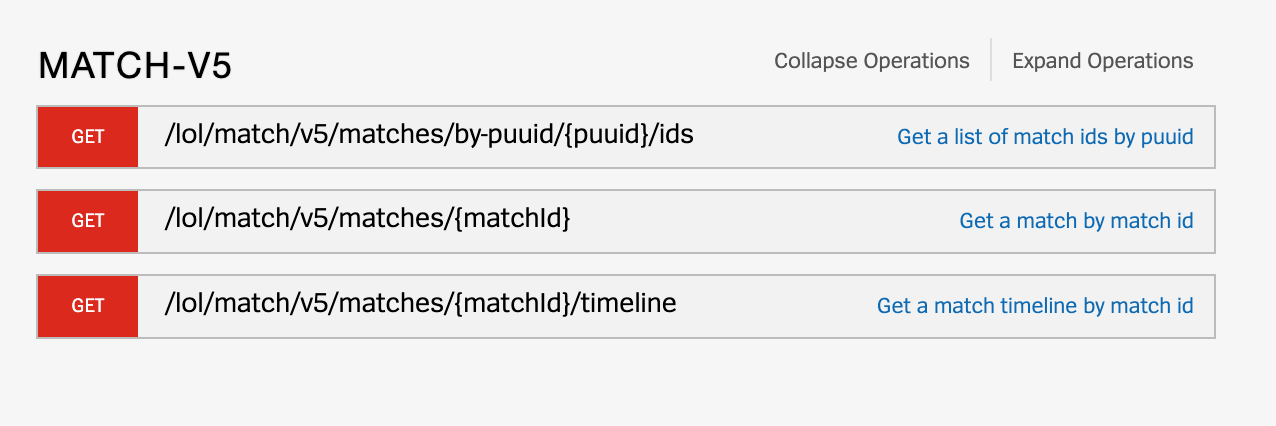

그 중에서도 3번째 Get a match timeline by match id 하는 방법

참고: https://shinminyong.tistory.com/30
(MATCH-V4를 이용한 데이터 수집 방법이어서 V5에 맞게 수정함)

## 1. Timeline 데이터 불러오기

사실 Timeline 데이터만 불러왔으면 자신이 분석할 방향에 맞게 구축할 데이터셋을 정의하고 다양한 방법론에 의거해서 데이터를 구축하시면 되는데요!

API를 처음 사용하시거나 불러온 데이터에 대한 설명을 Riot API description을 봐도 이해가 안되시는 분들이 꽤 있으실 것이라 생각이 되므로 해당 API를 통해 불러온 데이터는 어떤 데이터가 존재하며, 저는 어떻게 구축했는지에 대해서 설명해드리도록 하겠습니다!

In [24]:
my_api = "RGAPI-5e00a5ca-8147-41b6-9c45-666fd62ec3e2"
# api는 매일 갱신해주세요

match_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}/timeline?api_key=' + my_api

In [44]:
req = requests.get(match_url.format('KR_6500937300')) # 특정 Match id 를 이미 수집하였다고 가정. 
req.json()

{'metadata': {'dataVersion': '2',
  'matchId': 'KR_6500937300',
  'participants': ['5VFnKHCEcjLZn_Q7Gyn7bFpoPa_s6L6C8rYKuSdI1XVb8HrYc96n1NzG8inzxQVB5joFhfa2YiYnJA',
   '2VPlDUUyfNgNkIbXPsKCErrP649pawfWlYZxzLs1ZLBQig9527F1dcnMuFGBFWCCe89KMFUm_k6Mxw',
   'Q68wW79QpC7IeTHA0MV6hJykoGZ9orc2_4LyTnEGElznqdhB1LXvBP1Qn0V6TEZ245i_IVMxg4GGEQ',
   'wwObsuPZFVfaR4ACHErQp0JIg8mX37PRyf-fqmhdPH_8FvNBVeVk_rH6jNqIKiyxK7M--gSu0vaeUA',
   'xdVMFkfruBGLvuf06M9CncKel6OZgTSCY6EP_brZ78q-nKHnVF4wpHNvOcnD3veVh01CMGZJZoGNBg',
   'RbR_TwMnf6AXAPK_AKel9LWL_H8gi5TDYbLYLyTNQlkywrLbPNbPSLt-hZO-ARbKhdfBT10siUOcQw',
   'OaB4d7m4FSe6rcMClHyKmpuKxmnQpiVxKYpJOqkRxGyIPghG68t_5KCuQGMSo1QB3MS_2mkS_XGeDA',
   'V5XaELs-53Sqk45r911xHRsQ0w0bRJiuthBHovhRUtIeKrphYD5t6R-mOEMITMQdXPyuDJJPeo6ZoA',
   'F5ovmbv6iKmZA0Js7vtKlbROZc9-DJsSw-zFe9M0rZxRiy2aU3bWOpGEmX_5EDmbAU2U976r8LGhmQ',
   'ql9C_tnvqmsY_-n8ltXQhZjUnV6Hair-ceTZa96lBcIslVQq_AsW9Yszdvxzq7NDwBYZ-znm-SfnXQ']},
 'info': {'frameInterval': 60000,
  'frames': [{'events': [{'realTim

게임ID KR_6500937300 데이터를 json형태로 쭉 확인해보면 무수히 많은 json형태의 데이터들이 나열될 것입니다.

일단 json 데이터에 어떤 키값들이 존재하는지 확인해보겠습니다.



In [26]:
req.json().keys()

dict_keys(['metadata', 'info'])

Key값의 정보로는 metadata와 info 정보가 있습니다.

In [27]:
req.json()['metadata'].keys()

dict_keys(['dataVersion', 'matchId', 'participants'])

metadata의 key 값으로는 dataVersion, matchId,participants가 있습니다

위의 raw jason data를 확인하면,
- dataVersion은 뭔지 모르겠고 
- matchId는 현재 진행중인 게임의 고유 id, 
- 그리고 10명의 참가자들의 고유id가 포함되어있습니다.

우리가 관심있는 데이터는 그 다음 key값인 info에 있습니다.

In [28]:
req.json()['info'].keys()

dict_keys(['frameInterval', 'frames', 'gameId', 'participants'])

각 info의 key 값으로는 frameInterval, frames,gameId, participants가 있습니다.

이 중에서 frames 내의 데이터를 주로 활용할 것입니다.

frames는 게임 시작 후 1분씩 데이터를 분할하여 볼 수 있는 것 입니다.

In [30]:
req.json()['info']['frames'][0].keys()

dict_keys(['events', 'participantFrames', 'timestamp'])

각 frames의 key값으로는 participantFrames, events, timestamp값이 있습니다. 각 변수에 대해서 설명하자면

 

- participantFrames : 게임에 참여한 10명의 소환사에 대한 정보

- events : 각 소환사들이 행동한 events log

- timestamp : 소환사들의 정보나 행동한 기록이 게임이 시작한 후 얼마만큼 지나서 이뤄졌는지 알 수 있는 시간기록(Timeline)

 

데이터 셋을 구축하기 앞서 어떤 데이터가 존재하는지 알아야지 원하는 방향으로 데이터를 구축할 수 있기 때문에 위의 각 frames 내부에 있는 데이터에 대해서 설명드리도록 하겠습니다.

In [31]:
req.json()['info']['frames'][0]['participantFrames'].keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

### 2-1. participantFrames

In [34]:
req.json()['info']['frames'][0]['participantFrames']['1']

{'championStats': {'abilityHaste': 0,
  'abilityPower': 0,
  'armor': 30,
  'armorPen': 0,
  'armorPenPercent': 0,
  'attackDamage': 25,
  'attackSpeed': 100,
  'bonusArmorPenPercent': 0,
  'bonusMagicPenPercent': 0,
  'ccReduction': 0,
  'cooldownReduction': 0,
  'health': 590,
  'healthMax': 590,
  'healthRegen': 0,
  'lifesteal': 0,
  'magicPen': 0,
  'magicPenPercent': 0,
  'magicResist': 32,
  'movementSpeed': 345,
  'omnivamp': 0,
  'physicalVamp': 0,
  'power': 100,
  'powerMax': 100,
  'powerRegen': 0,
  'spellVamp': 0},
 'currentGold': 500,
 'damageStats': {'magicDamageDone': 0,
  'magicDamageDoneToChampions': 0,
  'magicDamageTaken': 0,
  'physicalDamageDone': 0,
  'physicalDamageDoneToChampions': 0,
  'physicalDamageTaken': 0,
  'totalDamageDone': 0,
  'totalDamageDoneToChampions': 0,
  'totalDamageTaken': 0,
  'trueDamageDone': 0,
  'trueDamageDoneToChampions': 0,
  'trueDamageTaken': 0},
 'goldPerSecond': 0,
 'jungleMinionsKilled': 0,
 'level': 1,
 'minionsKilled': 0,
 'pa

In [35]:
req.json()['info']['frames'][0]['participantFrames']['1'].keys()

dict_keys(['championStats', 'currentGold', 'damageStats', 'goldPerSecond', 'jungleMinionsKilled', 'level', 'minionsKilled', 'participantId', 'position', 'timeEnemySpentControlled', 'totalGold', 'xp'])

participantFrames에 key값으로 걸려있는 1~10 유저는 실제 participantId를 뜻하지 않으며 participantId는 해당 json내부 데이터에 존재하고 있습니다.

- championStats : 현재 상태. 체력 방어력 마법저항력 공격력 주문력 이동속도 공격속도 등등등 - 필요없음

{'abilityHaste': 0,
  'abilityPower': 0,
  'armor': 30,
  'armorPen': 0,
  'armorPenPercent': 0,
  'attackDamage': 25,
  'attackSpeed': 100,
  'bonusArmorPenPercent': 0,
  'bonusMagicPenPercent': 0,
  'ccReduction': 0,
  'cooldownReduction': 0,
  'health': 590,
  'healthMax': 590,
  'healthRegen': 0,
  'lifesteal': 0,
  'magicPen': 0,
  'magicPenPercent': 0,
  'magicResist': 32,
  'movementSpeed': 345,
  'omnivamp': 0,
  'physicalVamp': 0,
  'power': 100,
  'powerMax': 100,
  'powerRegen': 0,
  'spellVamp': 0},
  
  
- currentGold : 해당 소환사가 지니고 있는 골드 - 필요없음
 
- **damageStats** : 이거 필요함!!!

0분 데이터라 데미지가 다 0이지만 데미지로 포지션 별 1인분 평가를 할 수 있지 않을까?


{'magicDamageDone': 0,               
  'magicDamageDoneToChampions': 0,      # 미드 소환사 평가 지표 (+탑?)
  'magicDamageTaken': 0,              
  'physicalDamageDone': 0,          
  'physicalDamageDoneToChampions': 0,   # 원딜 소환사 평가 지표 (+탑?)
  'physicalDamageTaken': 0,
  'totalDamageDone': 0,
  'totalDamageDoneToChampions': 0,
  'totalDamageTaken': 0,              # 탱커 소환사 ( 탑, 정글?, 서폿?)  포지션 별 챔피언 특성에 따라 또 평가 지표가 달라야 하겠구나
  'trueDamageDone': 0,
  'trueDamageDoneToChampions': 0,
  'trueDamageTaken': 0},


- goldPerSecond

- jungleMinionsKilled

- level : 해당 챔피언의 레벨

- minionskilled : 해당 소환사가 죽인 미니언 수

- participantId : 인게임 참여한 소환사 id

- **position** : 해당 소환사의 현 timestamp 위치 - 필요함~

{'x': 554, 'y': 581},

- timeEnemySpentControlled : 뭔지 잘 모르겠음

- totalGold : 해당 소환사가 총 벌어들인 골드

- xp : 해당 챔피언의 경험치



### 한타 정의

한타: 
- (1) 같은 팀 5명(혹은 4명)의 거리가 n 이하일 때. 
- (2) 상대방에게 입힌 데미지가 갑자기 증가하였을 때. - 솔로킬과 대비
- (3) kill이 5분 내에 n명 이상 발생하였을 때.


### 한타 : (1) 같은 팀 5명(혹은 4명)의 거리가 n 이하일 때 시작되고, 약 n분간 유지된다. 

In [60]:
# 위치 데이터로 한타 여부 확인하기

# Step 1. 0분 frame에서 각 소환사의 위치 확인
for i in range(1, 11):
    position_1 = req.json()['info']['frames'][0]['participantFrames'][str(i)]['position']
    print(f"Position of participant {i}: {position_1}")



Position of participant 1: {'x': 554, 'y': 581}
Position of participant 2: {'x': 593, 'y': 464}
Position of participant 3: {'x': 557, 'y': 345}
Position of participant 4: {'x': 458, 'y': 271}
Position of participant 5: {'x': 335, 'y': 269}
Position of participant 6: {'x': 14500, 'y': 14511}
Position of participant 7: {'x': 14539, 'y': 14394}
Position of participant 8: {'x': 14503, 'y': 14275}
Position of participant 9: {'x': 14404, 'y': 14201}
Position of participant 10: {'x': 14281, 'y': 14199}


In [63]:
# Step 2. 0분 frame에서 팀별 2명의 소환사의 거리 확인

import math

blue_team = [1, 2, 3, 4, 5]
red_team = [6, 7, 8, 9, 10]

def calculate_distance(position1, position2):
    x1, y1 = position1['x'], position1['y']
    x2, y2 = position2['x'], position2['y']
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

# Calculate distance within blue team
for i in range(len(blue_team)):
    for j in range(i + 1, len(blue_team)):
        participant1 = blue_team[i]
        participant2 = blue_team[j]
        distance = calculate_distance(
            req.json()['info']['frames'][0]['participantFrames'][str(participant1)]['position'],
            req.json()['info']['frames'][0]['participantFrames'][str(participant2)]['position']
        )
        print(f"Distance between participant {participant1} and participant {participant2} in blue team: {round(distance)}")

# Calculate distance within red team
for i in range(len(red_team)):
    for j in range(i + 1, len(red_team)):
        participant1 = red_team[i]
        participant2 = red_team[j]
        distance = calculate_distance(
            req.json()['info']['frames'][0]['participantFrames'][str(participant1)]['position'],
            req.json()['info']['frames'][0]['participantFrames'][str(participant2)]['position']
        )
        print(f"Distance between participant {participant1} and participant {participant2} in red team: {round(distance)}")


Distance between participant 1 and participant 2 in blue team: 123
Distance between participant 1 and participant 3 in blue team: 236
Distance between participant 1 and participant 4 in blue team: 325
Distance between participant 1 and participant 5 in blue team: 381
Distance between participant 2 and participant 3 in blue team: 124
Distance between participant 2 and participant 4 in blue team: 236
Distance between participant 2 and participant 5 in blue team: 323
Distance between participant 3 and participant 4 in blue team: 124
Distance between participant 3 and participant 5 in blue team: 235
Distance between participant 4 and participant 5 in blue team: 123
Distance between participant 6 and participant 7 in red team: 123
Distance between participant 6 and participant 8 in red team: 236
Distance between participant 6 and participant 9 in red team: 325
Distance between participant 6 and participant 10 in red team: 381
Distance between participant 7 and participant 8 in red team: 124

In [68]:
# Step 3. 0분 frame에서 팀 전체 소환사의 거리 확인

# Calculate overall distance within blue team
total_distance_blue = 0
pair_count_blue = 0
for i in range(len(blue_team)):
    for j in range(i + 1, len(blue_team)):
        participant1 = blue_team[i]
        participant2 = blue_team[j]
        distance = calculate_distance(
            req.json()['info']['frames'][0]['participantFrames'][str(participant1)]['position'],
            req.json()['info']['frames'][0]['participantFrames'][str(participant2)]['position']
        )
        total_distance_blue += distance
        pair_count_blue += 1

average_distance_blue = total_distance_blue / pair_count_blue # 2명씩 거리 구한것의 평균
print(f"Average distance within blue team: {round(average_distance_blue)}")

# Calculate overall distance within red team
total_distance_red = 0
pair_count_red = 0
for i in range(len(red_team)):
    for j in range(i + 1, len(red_team)):
        participant1 = red_team[i]
        participant2 = red_team[j]
        distance = calculate_distance(
            req.json()['info']['frames'][0]['participantFrames'][str(participant1)]['position'],
            req.json()['info']['frames'][0]['participantFrames'][str(participant2)]['position']
        )
        total_distance_red += distance
        pair_count_red += 1

average_distance_red = total_distance_red / pair_count_red
print(f"Average distance within red team: {round(average_distance_red)}")


Average distance within blue team: 223
Average distance within red team: 223


게임이 시작하자 마자 (우물에 있을 때) 소환사간의 거리는 평균 223이다. 

각 분마다 거리를 확인하고, 300 이하일 때 출력해보자


In [80]:
# Step 4. 전체 frame에서 팀간의 거리 확인. 300 이하일 때 frame 출력 

data = req.json()['info']['frames']  # Assuming req.json() returns the game data

threshold_distance = 300
for frame_number, frame in enumerate(data):
    blue_distance_smaller = False
    red_distance_smaller = False

    # Check distance within blue team
    for i in range(len(blue_team)):
        for j in range(i + 1, len(blue_team)):
            participant1 = blue_team[i]
            participant2 = blue_team[j]
            distance = calculate_distance(
                frame['participantFrames'][str(participant1)]['position'],
                frame['participantFrames'][str(participant2)]['position']
            )
            if distance < threshold_distance:
                blue_distance_smaller = True
                break
        if blue_distance_smaller:
            break

    # Check distance within red team
    for i in range(len(red_team)):
        for j in range(i + 1, len(red_team)):
            participant1 = red_team[i]
            participant2 = red_team[j]
            distance = calculate_distance(
                frame['participantFrames'][str(participant1)]['position'],
                frame['participantFrames'][str(participant2)]['position']
            )
            if distance < threshold_distance:
                red_distance_smaller = True
                break
        if red_distance_smaller:
            break

    if blue_distance_smaller:
        print(f"Blue team members got closer in frame {frame_number}")
    if red_distance_smaller:
        print(f"Red team members got closer in frame {frame_number}")


Blue team members got closer in frame 0
Red team members got closer in frame 0
Red team members got closer in frame 1
Red team members got closer in frame 2
Red team members got closer in frame 3
Red team members got closer in frame 4
Blue team members got closer in frame 10
Blue team members got closer in frame 12
Red team members got closer in frame 14


더 생각해야 할 것들

- 어느정도 거리 이내에 모여있어야 한타 진행중이라고 판단할 수 있을까? 

    - 실제 데이터를 같이 봐야 알 수 있을것 같다.

- 그리고 4명만 모였을 때 팀의 distance로 판단해야 할 수도 있음
    (탑이나 정글 한타에 안올수도 - 그럼 한타에 참여하지 않은 소환사는 어떻게 평가해? 포탑 부시던가 정글 데미지 입힌거?)
    
- 한타 시작 시점을 정의했는데, 끝나는 시점은 어떻게 정의할 수 있을까? 

- 한타 중의 데이터로 각 라인별 1인분 여부를 판단한다면 사용 지표는 뭐가있을까?

    - 탑 : 'totalDamageTaken' , 'totalDamageDoneToChampions'
    - 미드 : 'magicDamageDoneToChampions' , 'totalDamageDoneToChampions'
    - 정글 : 'totalDamageTaken' , 정글 킬 이벤트
    - 원딜 : 'totalDamageDoneToChampions', 
    - 서폿 : 'totalDamageTaken' , 와드관련 이벤트, 힐이나 방어막 정보는 어디있지? , 이동방해 관련 ? 
    
    라인별 분류보다 더 세부적으로 해야할까? 라인 + 챔피언 특성으로 ? 너무복잡 ㅠ

### 2-2. events

In [43]:
req.json()['info']['frames'][0]['events']

[{'realTimestamp': 1684421713872, 'timestamp': 0, 'type': 'PAUSE_END'}]

In [45]:
type_ls = []
for i in range(len(req.json()['info']['frames'])):
    for j in range(len(req.json()['info']['frames'][i]['events'])):
        type_ls.append((req.json()['info']['frames'][i]['events'][j]['type']))

set(type_ls)

{'BUILDING_KILL',
 'CHAMPION_KILL',
 'CHAMPION_SPECIAL_KILL',
 'ELITE_MONSTER_KILL',
 'GAME_END',
 'ITEM_DESTROYED',
 'ITEM_PURCHASED',
 'ITEM_SOLD',
 'ITEM_UNDO',
 'LEVEL_UP',
 'OBJECTIVE_BOUNTY_PRESTART',
 'PAUSE_END',
 'SKILL_LEVEL_UP',
 'TURRET_PLATE_DESTROYED',
 'WARD_KILL',
 'WARD_PLACED'}

보시는 것처럼 16개의 event가 있는 것을 확인할 수 있습니다.


이렇게 다양한 이벤트들이 존재하니 수집시 유의해서 데이터를 구축해야합니다.
 

유의해야한다는 것이 예를들어 Building_kill이 있으면 억제기인지, 타워인지, 넥서스인지에 대한 정보를 보여주며, 또한 어느라인(탑, 미드, 봇)의 오브젝트인지에 대한 데이터도 함께 있으므로 구분해서 구축해주셔도 될 것 같습니다. 

오브젝트를 파괴했는데 그 오브젝트가 어떤 것이며, 어떤 유저가 파괴했는지, 어떤 유저가 어시스트 했는지, 어느 라인을 파괴했는지 등에 대한 정보가 자세히 설명됩니다.

그리고 **모든 events마다 timestamp가 존재**하는데 이는 아래의 timestamp에 대해서 설명하면서 다시 한번 강조드리겠습니다.

### 2-3. Timestamp

Timestamp는 위의 유저들의 정보, 이벤트가 게임 시작 후 얼마나 지났을 때까지의 정보인지를 알려주는 데이터입니다.

현재 Riot API Timeline 데이터의 Timestamp단위는 밀리세컨(ms)단위로 초단위로 바꾸기 위해서는 1000을 곱해주거나 ms단위 그대로 사용해주시면 됩니다.

예를들어 Timestamp가 600000일 때 초단위로 환산하면 600초 즉, 게임 시작 후 10분까지의 데이터라고 보시면 됩니다.

In [38]:
req.json()['info']['frames'][0]['timestamp']

0

In [39]:
req.json()['info']['frames'][1]['timestamp'] 

60019

현재 보시는 시간은 frames가 1의 timestamp가 60000인 뜻은 frames 1에 있는 participantFrames, events가 게임 시작 후 1분까지의 데이터라는 뜻입니다. 

아까 위에서 각 events마다 timestamp가 존재한다고 말씀드렸는데요.

보시면 봇라인의 포탑을 파괴한 시간(timestamp)이 662265라고 나오죠? 그렇다는 것은 약 11분정도에 봇 라인의 타워를 파괴했다는 것으로 해당 정보들을 이용해서 시계열적인 events 기록을 데이터로 만들 수 있습니다.

## 3. 데이터 셋 구축 (오류고쳐야함 ! )

여기서부터는 아마 많은 분들의 다양한 방법론이 존재할테니 서로 다를 수 있지만 저는 데이터를 어떻게 구축했는지 공유드리고자 합니다.

앞서 언급한 것처럼 단순 Match API를 이용해서는 게임이 종료된 후의 모든 데이터를 받아오는 것이여서 사후적인 데이터로 작용할 수 밖에 없어 승리와 패배한 팀의 패턴은 알 수 있지만 n시간까지 주로 어떤 데이터의 패턴을 보여야 승리할 확률이 높아지거나, 패배할 확률이 높아지거나 즉, 승/패를 예측함에 있어서 논리적인 데이터가 아니게됩니다.

따라서 한타 시작 전후 n Minute 까지의 정보를 미리 알고(사전적 데이터) 승/패를 예측해보고자한타 시작 전후 n Minute까지의 데이터를 구축해봤습니다. 코드는 아래와 같습니다.

- 함수 이해 후에
- 코드 변경해야 함

In [54]:
def riot_timeline_dataset(pre_dataset,api_key,timeline):
    
    challenger_game = pre_dataset
    my_api = api_key
    
    
    #수집할 컬럼 정의
    use_columns = ['gameId','blueWins','blueTotalGolds','blueCurrentGolds','blueTotalLevel'\
                           ,'blueAvgLevel','blueTotalMinionKills','blueTotalJungleMinionKills'
                           ,'blueFirstBlood','blueKill','blueDeath','blueAssist'\
                           ,'blueWardPlaced','blueWardKills','blueFirstTower','blueFirstInhibitor'\
                           ,'blueFirstTowerLane'\
                           ,'blueTowerKills','blueMidTowerKills','blueTopTowerKills','blueBotTowerKills'\
                           ,'blueInhibitor','blueFirstDragon','blueDragnoType','blueDragon','blueRiftHeralds'\
                           ,'redWins','redTotalGolds','redCurrentGolds','redTotalLevel'\
                           ,'redAvgLevel','redTotalMinionKills','redTotalJungleMinionKills'
                           ,'redFirstBlood','redKill','redDeath','redAssist'\
                           ,'redWardPlaced','redWardKills','redFirstTower','redFirstInhibitor'\
                           ,'redFirstTowerLane'\
                           ,'redTowerKills','redMidTowerKills','redTopTowerKills','redBotTowerKills'\
                           ,'redInhibitor','redFirstDragon','redDragnoType','redDragon','redRiftHeralds']

    challenger_timeline_df1 = pd.DataFrame()
    challenger_timeline_df = pd.DataFrame()
    error_list = []
    match_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}/timeline?api_key=' + my_api # 수정함

    for b in range(len(challenger_game)):


        try:
            game_id = challenger_game['gameId'].iloc[b]
            req = requests.get(match_url.format(game_id))
            print('status : ' + str(req.status_code) + '  loop location : ' + str(b))

            if req.status_code == 200:
                pass

            elif req.status_code == 429:
                print('api cost full : infinite loop start')
                print('loop location : ',b)
                start_time = time.time()

                while True:
                    if req.status_code == 429:

                        print('try 10 second wait time')
                        time.sleep(10)

                        req = requests.get(match_url.format(game_id))
                        print(req.status_code)

                    elif req.status_code == 200:
                        print('total wait time : ', time.time() - start_time)
                        print('recovery api cost')
                        break

            elif req.status_code == 503:
                print('service available error')
                start_time = time.time()

                while True:
                    if req.status_code == 503 or req.status_code == 429:

                        print('try 10 second wait time')
                        time.sleep(10)

                        req = requests.get(match_url.format(game_id))
                        print(req.status_code)

                    elif req.status_code == 200:
                        print('total error wait time : ', time.time() - start_time)
                        print('recovery api cost')
                        break
            elif req.status_code == 403: # api갱신이 필요
                print('you need api renewal')
                print('break')
                break

            '''
            pre_data0 = json_normalize(req.json())
            pre_data0['gameId'] = game_id

            pre_data = pre_data.append(pre_data0)
            '''
            
            #json data에서 필요한 frames 데이터만
            frames = req.json()['frames']
            
            #시작하고 n분 즉, 수집하고 싶은 시간까지의 인덱스가 어디있을지 추출하는 코드
            lc0 = 0 # 위치
            while True:
                try:
                    timestamps = frames[lc0]['timestamp']

                    if timestamps <= timeline: # n Minute를 설정(Ms단위의 timeline)
                        lc0 += 1

                    else:
                        lc = lc0-1
                        break
                except:
                    lc = lc0 - 1

                    break

            # participants 1~5 까지는 blueteam, 6~10까지는 redteam
            participant = frames[lc]['participantFrames']

            bluetotal_gold, bluecurrent_gold, bluetotal_level, \
            bluetotal_minionkill, bluetotal_jungleminionkill = [],[],[],[],[]

            redtotal_gold, redcurrent_gold, redtotal_level, \
            redtotal_minionkill, redtotal_jungleminionkill = [],[],[],[],[]


            for i in range(len(participant)):
                i = i+1
                if 1 <=participant[str(i)]['participantId'] <= 5:
                    bluetotal_gold.append(participant[str(i)]['totalGold'])
                    bluecurrent_gold.append(participant[str(i)]['currentGold'])
                    bluetotal_level.append(participant[str(i)]['level'])
                    bluetotal_minionkill.append(participant[str(i)]['minionsKilled'])
                    bluetotal_jungleminionkill.append(participant[str(i)]['jungleMinionsKilled'])
                else:
                    redtotal_gold.append(participant[str(i)]['totalGold'])
                    redcurrent_gold.append(participant[str(i)]['currentGold'])
                    redtotal_level.append(participant[str(i)]['level'])
                    redtotal_minionkill.append(participant[str(i)]['minionsKilled'])
                    redtotal_jungleminionkill.append(participant[str(i)]['jungleMinionsKilled'])
            
            
            #timestamp별로 독립적인 변수들을 나타내므로 n분까지의 데이터를 수집하기 위해서는 계속 중첩해서 
            #더해줘야 함
            blue_kill, red_kill = 0,0
            blue_firstkill, red_firstkill = 0,0
            blue_assist, red_assist = 0,0
            red_death, blue_death = 0,0
            blue_wardplace, red_wardplace = 0,0
            blue_wardkill, red_wardkill = 0,0
            blue_elite, red_elite = 0,0
            blue_rift, red_rift = 0,0
            blue_dragon, red_dragon = 0,0
            blue_baron, red_baron = 0,0
            blue_firstdragon, red_firstdragon = 0,0
            blue_dragontype, red_dragontype = [],[]
            blue_firstbaron, red_firstbaron = 0,0
            blue_tower,red_tower = 0,0
            blue_firsttower, red_firsttower = 0,0
            blue_firsttowerlane, red_firsttowerlane = [],[]
            blue_midtower, red_midtower = 0,0
            blue_toptower, red_toptower = 0,0
            blue_bottower, red_bottower = 0,0
            blue_inhibitor, red_inhibitor = 0,0
            blue_firstinhibitor, red_firstinhibitor = 0,0



            for y in range(1,lc+1): # events 
                events = frames[y]['events']

                for x in range(len(events)):
                    if events[x]['type'] == 'WARD_KILL':
                        if 1 <= events[x]['killerId'] <= 5:
                            blue_wardkill += 1
                        else:
                            red_wardkill += 1

                    elif events[x]['type'] == 'WARD_PLACED':
                        if 1 <= events[x]['creatorId'] <= 5:
                            blue_wardplace += 1
                        else:
                            red_wardplace += 1

                    elif events[x]['type'] == 'CHAMPION_KILL': 
                        if 1 <= events[x]['killerId'] <= 5:
                            if red_kill ==0 and blue_kill ==0:
                                blue_firstkill += 0

                            else:
                                pass

                            blue_kill += 1
                            blue_assist += len(events[x]['assistingParticipantIds'])
                            red_death += 1


                        else:
                            if red_kill ==0 and blue_kill ==0:
                                red_firstkill += 0

                            else:
                                pass

                            red_kill += 1
                            red_assist += len(events[x]['assistingParticipantIds'])
                            blue_death += 1



                    elif events[x]['type'] == 'ELITE_MONSTER_KILL':
                        if 1 <= events[x]['killerId'] <= 5:
                            blue_elite += 1

                            if events[x]['monsterType']== 'DRAGON':
                                if red_dragon ==0 and blue_dragon == 0:
                                     blue_firstdragon += 1
                                else:
                                    pass

                                blue_dragontype.append(events[x]['monsterSubType'])
                                blue_dragon += 1



                            elif events[x]['monsterType']== 'RIFTHERALD':
                                blue_rift += 1

                            elif events[x]['monsterType']== 'BARON_NASHOR':
                                if red_baron ==0 and blue_dragon == 0:
                                     blue_firstbaron += 1
                                else:
                                    pass

                                blue_baron += 1

                        else:
                            red_elite += 1

                            if events[x]['monsterType']== 'DRAGON':
                                if red_dragon ==0 and blue_dragon == 0:
                                     red_firstdragon += 1
                                else:
                                    pass

                                red_dragontype.append(events[x]['monsterSubType'])
                                red_dragon += 1



                            elif events[x]['monsterType']== 'RIFTHERALD':
                                red_rift += 1

                            elif events[x]['monsterType']== 'BARON_NASHOR':
                                if red_baron ==0 and blue_dragon == 0:
                                     red_firstbaron += 1
                                else:
                                    pass

                                red_baron += 1

                    elif events[x]['type'] == 'BUILDING_KILL':
                        if 1 <= events[x]['killerId'] <= 5:

                            if events[x]['buildingType'] == 'TOWER_BUILDING':
                                if red_tower == 0 and blue_tower ==0:
                                    blue_firsttower += 1
                                    blue_firsttowerlane.append(events[x]['laneType'])

                                else:
                                    pass

                                blue_tower += 1

                                if events[x]['laneType'] == 'MID_LANE':
                                    blue_midtower += 1

                                elif events[x]['laneType'] == 'TOP_LANE':
                                    blue_toptower += 1

                                elif events[x]['laneType'] == 'BOT_LANE':
                                    blue_bottower += 1



                            elif events[x]['buildingType'] == 'INHIBITOR_BUILDING':
                                if red_inhibitor == 0 and blue_inhibitor ==0:
                                    blue_firstinhibitor += 1

                                else:
                                    pass

                                blue_inhibitor += 1

                        else:
                            if events[x]['buildingType'] == 'TOWER_BUILDING':
                                if red_tower == 0 and blue_tower ==0:
                                    red_firsttower += 1
                                    red_firsttowerlane.append(events[x]['laneType'])

                                else:
                                    pass

                                red_tower += 1

                                if events[x]['laneType'] == 'MID_LANE':
                                    red_midtower += 1

                                elif events[x]['laneType'] == 'TOP_LANE':
                                    red_toptower += 1

                                elif events[x]['laneType'] == 'BOT_LANE':
                                    red_bottower += 1

                            elif events[x]['buildingType'] == 'INHIBITOR_BUILDING':
                                if red_inhibitor == 0 and blue_inhibitor ==0:
                                    red_firstinhibitor += 1

                                else:
                                    pass

                                red_inhibitor += 1


            data_list = [game_id,challenger_game['blueWins'].iloc[b],np.sum(bluetotal_gold)\
                ,np.sum(bluecurrent_gold),np.sum(bluetotal_level),np.mean(bluetotal_level)\
                ,np.sum(bluetotal_minionkill),np.sum(bluetotal_jungleminionkill)\
                ,blue_firstkill,blue_kill,blue_death,blue_assist,blue_wardplace,blue_wardkill\
                ,blue_firsttower,blue_firstinhibitor,blue_firsttowerlane,blue_tower\
                ,blue_midtower,blue_toptower,blue_bottower,blue_inhibitor,blue_firstdragon\
                ,blue_dragontype,blue_dragon,blue_rift\
                ,challenger_game['redWins'].iloc[b],np.sum(redtotal_gold)\
                ,np.sum(redcurrent_gold),np.sum(redtotal_level),np.mean(redtotal_level)\
                ,np.sum(redtotal_minionkill),np.sum(redtotal_jungleminionkill)\
                ,red_firstkill,red_kill,red_death,red_assist,red_wardplace,red_wardkill\
                ,red_firsttower,red_firstinhibitor,red_firsttowerlane,red_tower\
                ,red_midtower,red_toptower,red_bottower,red_inhibitor,red_firstdragon\
                ,red_dragontype,red_dragon,red_rift]

            challenger_timeline_df0 = pd.DataFrame(np.array([data_list]), columns = use_columns)   
            challenger_timeline_df1 = challenger_timeline_df1.append(challenger_timeline_df0)

            print('data crawling success')

            if b != 0 and b % 2000 == 0 : #feature가 많다보니 반복문 2000씩 끊어서 수집
                challenger_timeline_df = challenger_timeline_df.append(challenger_timeline_df1)
                challenger_timeline_df1 = pd.DataFrame()

        
        except: #에러발생 시 바로 다음 반복문으로 넘어가게끔
            print('error visual')
            error_list.append(b)
            pass
    challenger_timeline_df = challenger_timeline_df.append(challenger_timeline_df1)
    
    return challenger_timeline_df

In [55]:
pre_dataset = 'KR_6500937300' # 이게뭐지?
api_key = my_api
timeline = 5

riot_timeline_dataset(pre_dataset,api_key,timeline)

error visual
error visual
error visual
error visual
error visual
error visual
error visual
error visual
error visual
error visual
error visual
error visual
error visual


/var/folders/29/nzc3vbbx2xgfy9nbyx8n7tv80000gn/T/ipykernel_17805/1972071470.py:344: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  challenger_timeline_df = challenger_timeline_df.append(challenger_timeline_df1)


""


### challenger_game 이 뭐지 ?
https://www.kaggle.com/datasets/gyejr95/league-of-legends-challenger-ranked-games2020

- 블로거가 정리해 놓은 데이터셋 다운받아봄
- 2020년 api를 이용해서 많이 다름
    - gameId -> matchId 등등등


In [51]:
challenger_game = pd.read_csv('Challenger_Ranked_Games.csv')
challenger_game.head()

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,4247263043,1323,0,1,0,0,0,0,0,0,...,68,73016,49832,533,64,12.8,138,8,38711,60463
1,4247155821,1317,1,0,0,0,1,0,2,0,...,8,44218,37136,571,59,11.8,134,3,24829,14105
2,4243963257,932,0,0,0,0,0,0,0,0,...,20,30797,35364,400,50,10.0,89,5,12589,45201
3,4241678498,2098,0,0,0,1,1,0,1,1,...,72,125866,70528,832,84,16.8,205,9,65312,88202
4,4241538868,2344,1,1,1,1,1,1,2,2,...,83,131536,74596,794,85,17.0,227,7,86431,64141


In [53]:
challenger_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26904 entries, 0 to 26903
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   26904 non-null  int64  
 1   gameDuraton              26904 non-null  int64  
 2   blueWins                 26904 non-null  int64  
 3   blueFirstBlood           26904 non-null  int64  
 4   blueFirstTower           26904 non-null  int64  
 5   blueFirstBaron           26904 non-null  int64  
 6   blueFirstDragon          26904 non-null  int64  
 7   blueFirstInhibitor       26904 non-null  int64  
 8   blueDragonKills          26904 non-null  int64  
 9   blueBaronKills           26904 non-null  int64  
 10  blueTowerKills           26904 non-null  int64  
 11  blueInhibitorKills       26904 non-null  int64  
 12  blueWardPlaced           26904 non-null  int64  
 13  blueWardkills            26904 non-null  int64  
 14  blueKills             

### 이건 어디서 가져온 데이터지?
-  /lol/match/v5/matches/{matchId} 같음
- get a match by match id